In [10]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Circle
import xclimate as xclim

In [2]:
%load_ext autoreload
%autoreload 2

%aimport xclimate

In [ ]:
GRID = xclim.load_fhist_ppe_grid()

NONGLC_PCT_THRESHOLD = 80
NONGLC_MASK = GRID.PCT_GLC < NONGLC_PCT_THRESHOLD

In [53]:
TIME_SLICE = slice("1995-01", "1996-12")

In [ ]:
# Load variables
FHIST = {}
FHIST["PRECT_day_1"] = xclim.load_coupled_fhist_ppe("PRECT", "atm", "day_1", "h2", keep_var_only=True)["PRECT"].sel(time=TIME_SLICE)
FHIST["PRECC_month_1"] = xclim.load_coupled_fhist_ppe("PRECC", "atm", "month_1", "h0", keep_var_only=True)["PRECC"].sel(time=TIME_SLICE)
FHIST["PRECL_month_1"] = xclim.load_coupled_fhist_ppe("PRECL", "atm", "month_1", "h0", keep_var_only=True)["PRECL"].sel(time=TIME_SLICE)
FHIST["TLAI_month_1"] = xclim.load_coupled_fhist_ppe("TLAI", "lnd", "month_1", "h0", keep_var_only=True)["TLAI"].sel(time=TIME_SLICE).reindex_like(GRID, method="nearest", tolerance=1e-3)
FHIST["ET_month_1"] = xclim.load_coupled_fhist_ppe("EFLX_LH_TOT", "lnd", "month_1", "h0", keep_var_only=True)["EFLX_LH_TOT"].sel(time=TIME_SLICE).reindex_like(GRID, method="nearest", tolerance=1e-3)

In [56]:
# Compute derived variables

# Monthly precipitation rate (PRECC + PRECL)
FHIST["PRECT_month_1"] = FHIST["PRECC_month_1"] + FHIST["PRECL_month_1"]

# Annual mean TLAI
FHIST["TLAI_year_1"] = FHIST["TLAI_month_1"].sel(time=TIME_SLICE).groupby("time.year").map(lambda x: x.weighted(x.time.dt.days_in_month).mean("time"))

# Annual mean ET
FHIST["ET_year_1"] = FHIST["ET_month_1"].sel(time=TIME_SLICE).groupby("time.year").map(lambda x: x.weighted(x.time.dt.days_in_month).mean("time"))

# # Wet-day frequency as defined in Feldman et al. (2024) - the annual number of days with above 1 mm/day of precipitation
# DAILY_PRECT_THRESH =  1 / (1000 * 24 * 60 * 60)  # [m/s] = 1 [mm/day]
# FHIST["WDFRQ_year_1"] = (FHIST["PRECT_day_1"].sel(time=TIME_SLICE).where(LA_FHIST>0) > DAILY_PRECT_THRESH).groupby("time.year").sum()

# Annual difference between highest and lowest precipitation months
FHIST["PRDIFF_year_1"] = FHIST["PRECT_month_1"].groupby("time.year").map(lambda x: x.max(dim="time") - x.min(dim="time"))

In [57]:
# Load variables to disk (speeds up computation)
FHIST["ET_year_1"] = FHIST["ET_year_1"].load()
FHIST["TLAI_year_1"] = FHIST["TLAI_year_1"].load()
# FHIST["WDFRQ_year_1"] = FHIST["WDFRQ_year_1"].load()
FHIST["PRDIFF_year_1"] = FHIST["PRDIFF_year_1"].load()

In [82]:
nb = 15
qbinned_mean = xclim.get_quantile_binned_mean(
    Z=(FHIST["ET_year_1"].sel(member=slice(1, None)) - FHIST["ET_year_1"].sel(member=0)).where(NONGLC_MASK),
    xb=FHIST["PRDIFF_year_1"].sel(member=slice(1, None)).where(NONGLC_MASK),
    yb=FHIST["TLAI_year_1"].sel(member=slice(1, None)).where(NONGLC_MASK),
    xnb=nb,
    ynb=nb,
    quantile_dims=["lat", "lon", "year"],
    agg_dims=["gridcell"],
    use_numba=True,
)
# bm = qbinned_mean.binned_mean.compute()
# jh = qbinned_mean.joint_hist.compute()

In [68]:
qbinned_mean.binned_mean.shape

(26, 15, 15)

In [69]:
qbinned_mean.joint_hist.shape

(26, 15, 15)

In [85]:
qbinned_mean.xb_bin.unstack()

<xarray.DataArray (member: 26, lat: 96, lon: 144, year: 2)> Size: 6MB
dask.array<reshape, shape=(26, 96, 144, 2), dtype=float64, chunksize=(26, 96, 144, 2), chunktype=numpy.ndarray>
Coordinates:
  * member    (member) int64 208B 1 2 3 4 5 6 7 8 9 ... 20 21 22 23 24 25 26 27
  * lat       (lat) float64 768B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon       (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * year      (year) int64 16B 1995 1996
    time      object 8B 1950-01-01 00:00:00
    ltype     int64 8B 4
    landunit  object 8B 'ltype_landice_multiple_elevation_classes'
Attributes:
    units:         m/s
    cell_methods:  time: mean

In [75]:
qbinned_mean.xb_qedge.rename({"quantile": "x_qedge"})

<xarray.DataArray (x_qedge: 16, member: 26)> Size: 3kB
dask.array<transpose, shape=(16, 26), dtype=float64, chunksize=(16, 26), chunktype=numpy.ndarray>
Coordinates:
  * x_qedge  (x_qedge) float64 128B 0.0 0.06667 0.1333 0.2 ... 0.8667 0.9333 1.0
  * member   (member) int64 208B 1 2 3 4 5 6 7 8 9 ... 20 21 22 23 24 25 26 27
Attributes:
    units:         m/s
    cell_methods:  time: mean

In [80]:
xr.Dataset(
        {
            "binned_mean": qbinned_mean.binned_mean,
            "joint_hist": qbinned_mean.joint_hist,
            "xb_bin": qbinned_mean.xb_bin,
            "yb_bin": qbinned_mean.yb_bin,
            "xb_qedge": qbinned_mean.xb_qedge.rename({"quantile": "x_qedge"}),
            "yb_qedge": qbinned_mean.xb_qedge.rename({"quantile": "y_qedge"}),
        }
    ).drop_vars(["ltype", "landunit", "time"]).nbytes

12487264

In [ ]:
%%timeit
nb = 15
qbinned_mean = xclim.get_quantile_binned_mean(
    Z=(FHIST["ET_year_1"].sel(member=slice(1, None)) - FHIST["ET_year_1"].sel(member=0)).where(NONGLC_MASK),
    xb=FHIST["PRDIFF_year_1"].sel(member=slice(1, None)).where(NONGLC_MASK),
    yb=FHIST["TLAI_year_1"].sel(member=slice(1, None)).where(NONGLC_MASK),
    xnb=nb,
    ynb=nb,
    agg_dims=["gridcell", "year"],
    use_numba=False,
)
bm = qbinned_mean.binned_mean.compute()
jh = qbinned_mean.joint_hist.compute()

CPU times: user 26.3 s, sys: 6.71 s, total: 33 s
Wall time: 23.7 s


Text(0.7624338479276527, 0.0507027535362326, '200 points')

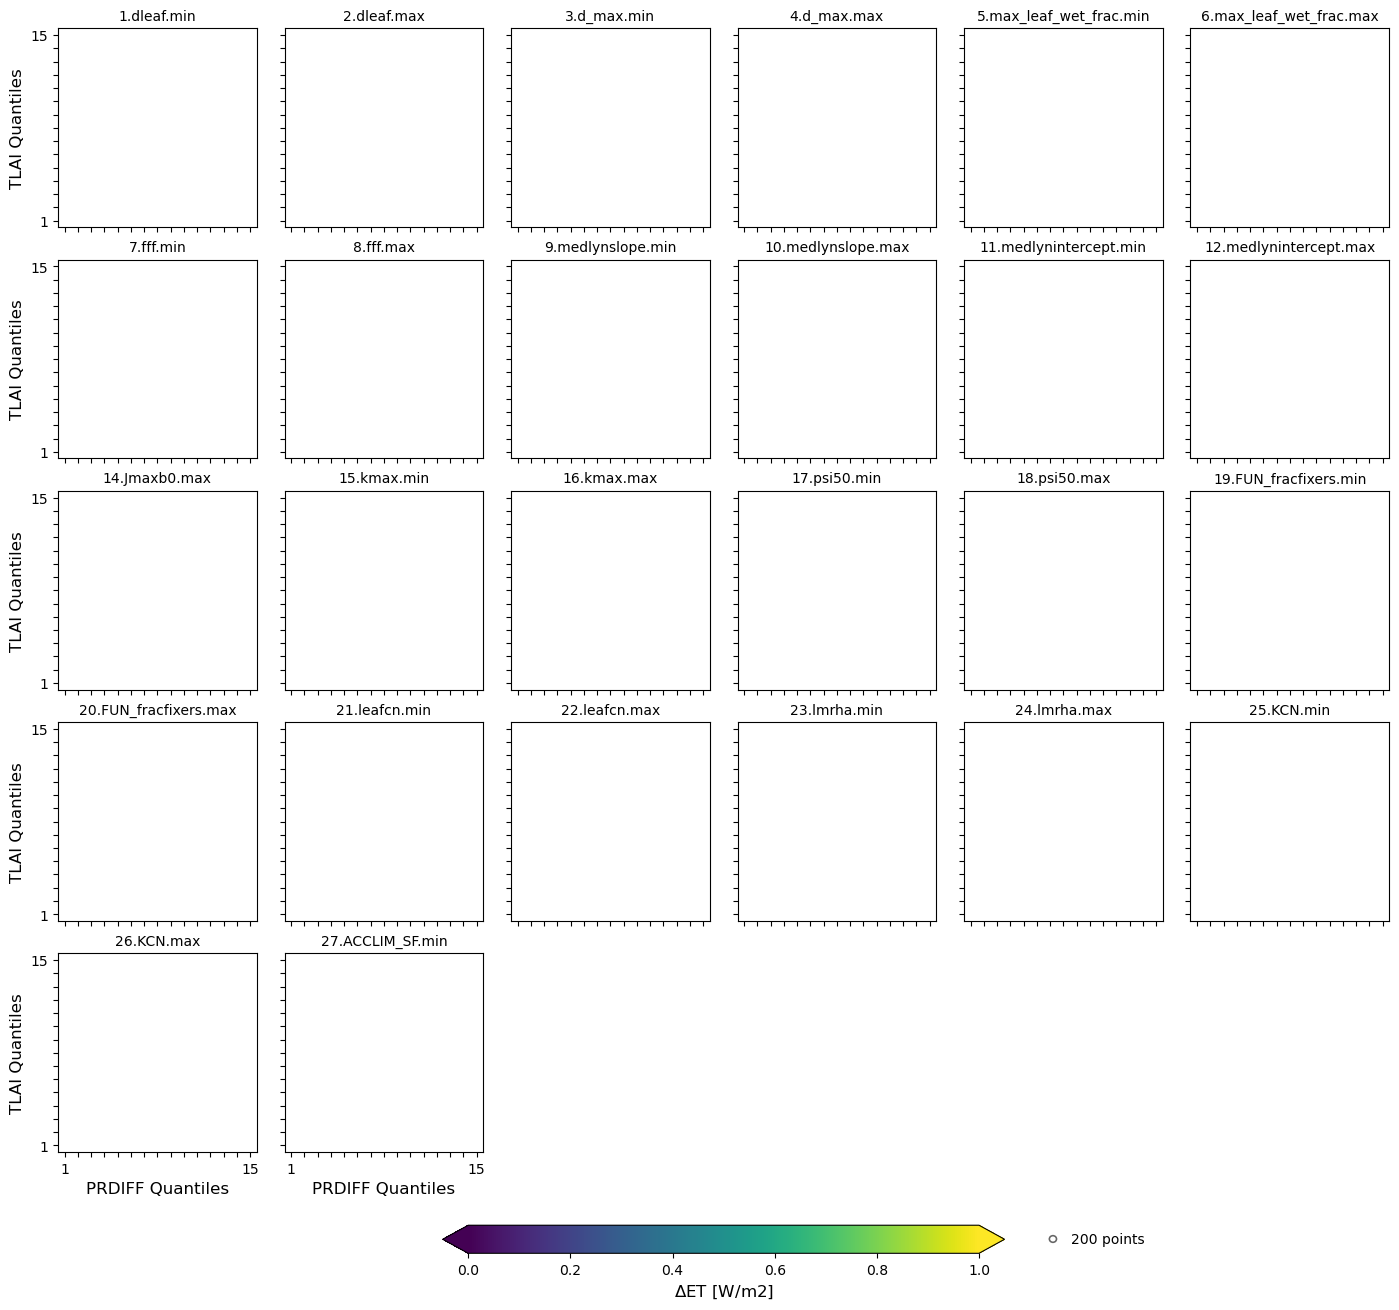

In [39]:
bm_data = bm
jh_data = jh
vabs = 8.5
ref_count = 300

ncols = 6
nrows = 5

fig, axs = plt.subplots(
    ncols=ncols, nrows=nrows,
    sharex=True, sharey=True,
    figsize=(14, 13),
    subplot_kw=dict(box_aspect=1),
    constrained_layout=True
)
ax = axs.flatten()

pcm = None
for i, m in enumerate(bm_data.member.values):
    # pcm = ax[i].pcolormesh(bm_data.sel(member=m), shading="auto", cmap="BrBG", vmin=-vabs, vmax=vabs)

    # m_jh_data = jh_data.sel(member=m)
    # for ii in range(len(jh_data.x_bin)):
    #     for jj in range(len(jh_data.y_bin)):
    #         count = m_jh_data.values[ii, jj]
    #         if count > 0:
    #             radius = 0.4 * (count / ref_count)
    #             lw = 0.5 + (count / ref_count)
    #             circle = Circle(
    #                 (ii + 0.5, jj + 0.5),
    #                 radius,
    #                 fill=False,
    #                 edgecolor="black",
    #                 linewidth=lw,
    #                 alpha=0.6,
    #             )
    #             ax[i].add_patch(circle)

    ax[i].set_title(xclim.ppe.get_member_name(m), fontsize=10)
    ax[i].set_xlim(0, len(bm_data.x_bin))
    ax[i].set_ylim(0, len(bm_data.y_bin))

    ax[i].set_yticks(np.arange(nb) + 0.5)
    ax[i].set_xticks(np.arange(nb) + 0.5)

    ticklabels = np.full((nb), "", dtype=object)
    ticklabels[0] = "1"
    ticklabels[-1] = str(nb)

    ax[i].set_yticklabels(ticklabels)
    ax[i].set_xticklabels(ticklabels)

    if i % ncols == 0:
        ax[i].set_ylabel("TLAI Quantiles", fontsize=12)
    if i // ncols == nrows - 1:
        ax[i].set_xlabel("PRDIFF Quantiles", fontsize=12)

# Add colorbar below all subplots
cbar = fig.colorbar(
    pcm,
    ax=axs,
    orientation="horizontal",
    extend="both",
    fraction=0.025,
    shrink=0.9,
    pad=0.025,
)
cbar.set_label("$\\Delta$ET [W/m2]", fontsize=12)

for i in range(len(bm_data.member), ncols * nrows):
    ax[i].remove()

# Add scale circle to the right of colorbar
scale_count = 200
scale_lw = (scale_count / ref_count) + 0.5

fig.canvas.draw()

# Get colorbar position
cbar_pos = cbar.ax.get_position()

# Position to the right of colorbar in figure coordinates
scale_x = cbar_pos.x1 + 0.05  # 0.05 figure units to the right
scale_y = (cbar_pos.y0 + cbar_pos.y1) / 2  # vertically centered

# Convert data radius to figure coordinates using transform pipeline
data_radius = 0.4 * (scale_count / ref_count)  # radius in data coordinates
# Transform from data coordinates to display (pixel) coordinates, then to figure coordinates
point_data = np.array([[0, 0], [data_radius, 0]])  # origin and point at radius distance
point_display = ax[0].transData.transform(point_data)
point_figure = fig.transFigure.inverted().transform(point_display)
scale_radius = np.linalg.norm(point_figure[1] - point_figure[0])  # distance in figure units

scale_circle = Circle(
    (scale_x, scale_y),
    scale_radius,
    fill=False,
    edgecolor="black",
    linewidth=scale_lw,
    alpha=0.6,
    clip_on=False,
    transform=fig.transFigure,
)
fig.add_artist(scale_circle)

fig.text(
    scale_x + scale_radius + 0.01,
    scale_y,
    f"{scale_count} points",
    ha="left",
    va="center",
    fontsize=10,
    transform=fig.transFigure,
)

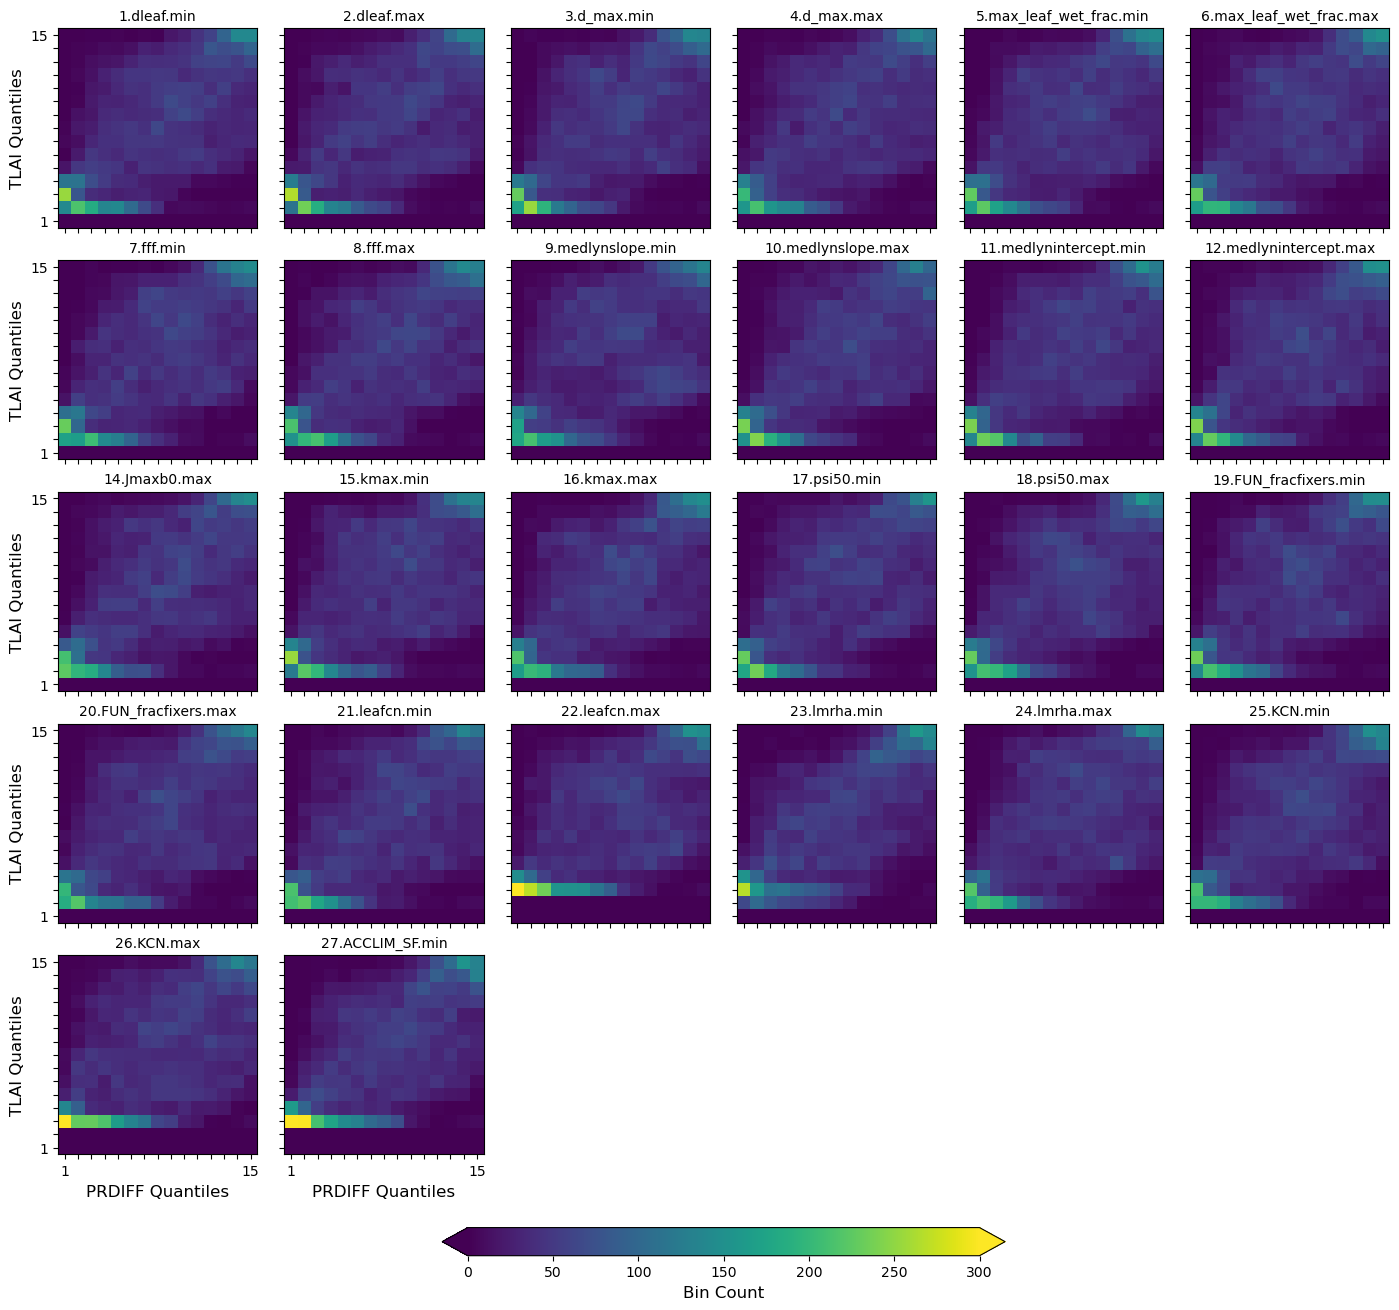

In [26]:
bm_data = bm
jh_data = jh
vabs = 300
ref_count = 300

ncols = 6
nrows = 5

fig, axs = plt.subplots(
    ncols=ncols, nrows=nrows,
    sharex=True, sharey=True,
    figsize=(14, 13),
    subplot_kw=dict(box_aspect=1),
    constrained_layout=True
)
ax = axs.flatten()

pcm = None
for i, m in enumerate(bm_data.member.values):
    pcm = ax[i].pcolormesh(jh_data.sel(member=m), shading="auto", cmap="viridis", vmin=0, vmax=vabs)

    # m_jh_data = jh_data.sel(member=m)
    # for ii in range(len(jh_data.x_bin)):
    #     for jj in range(len(jh_data.y_bin)):
    #         count = m_jh_data.values[ii, jj]
    #         if count > 0:
    #             radius = 0.4 * (count / ref_count)
    #             lw = 0.5 + (count / ref_count)
    #             circle = Circle(
    #                 (ii + 0.5, jj + 0.5),
    #                 radius,
    #                 fill=False,
    #                 edgecolor="black",
    #                 linewidth=lw,
    #                 alpha=0.6,
    #             )
    #             ax[i].add_patch(circle)

    ax[i].set_title(xclim.ppe.get_member_name(m), fontsize=10)
    ax[i].set_xlim(0, len(bm_data.x_bin))
    ax[i].set_ylim(0, len(bm_data.y_bin))

    ax[i].set_yticks(np.arange(nb) + 0.5)
    ax[i].set_xticks(np.arange(nb) + 0.5)

    ticklabels = np.full((nb), "", dtype=object)
    ticklabels[0] = "1"
    ticklabels[-1] = str(nb)

    ax[i].set_yticklabels(ticklabels)
    ax[i].set_xticklabels(ticklabels)

    if i % ncols == 0:
        ax[i].set_ylabel("TLAI Quantiles", fontsize=12)
    if i // ncols == nrows - 1:
        ax[i].set_xlabel("PRDIFF Quantiles", fontsize=12)

# Add colorbar below all subplots
cbar = fig.colorbar(
    pcm,
    ax=axs,
    orientation="horizontal",
    extend="both",
    fraction=0.025,
    shrink=0.9,
    pad=0.025,
)
cbar.set_label("Bin Count", fontsize=12)

for i in range(len(bm_data.member), ncols * nrows):
    ax[i].remove()

# # Add scale circle to the right of colorbar
# scale_count = 200
# scale_lw = (scale_count / ref_count) + 0.5

# fig.canvas.draw()

# # Get colorbar position
# cbar_pos = cbar.ax.get_position()

# # Position to the right of colorbar in figure coordinates
# scale_x = cbar_pos.x1 + 0.05  # 0.05 figure units to the right
# scale_y = (cbar_pos.y0 + cbar_pos.y1) / 2  # vertically centered

# # Convert data radius to figure coordinates using transform pipeline
# data_radius = 0.4 * (scale_count / ref_count)  # radius in data coordinates
# # Transform from data coordinates to display (pixel) coordinates, then to figure coordinates
# point_data = np.array([[0, 0], [data_radius, 0]])  # origin and point at radius distance
# point_display = ax[0].transData.transform(point_data)
# point_figure = fig.transFigure.inverted().transform(point_display)
# scale_radius = np.linalg.norm(point_figure[1] - point_figure[0])  # distance in figure units

# scale_circle = Circle(
#     (scale_x, scale_y),
#     scale_radius,
#     fill=False,
#     edgecolor="black",
#     linewidth=scale_lw,
#     alpha=0.6,
#     clip_on=False,
#     transform=fig.transFigure,
# )
# fig.add_artist(scale_circle)

# fig.text(
#     scale_x + scale_radius + 0.01,
#     scale_y,
#     f"{scale_count} points",
#     ha="left",
#     va="center",
#     fontsize=10,
#     transform=fig.transFigure,
# )

In [47]:
qbinned_mean = xclim.get_quantile_binned_mean(
    Z=(FHIST["ET_year_1"].sel(member=slice(1, None)) - FHIST["ET_year_1"].sel(member=0)).where(NONGLC_MASK),
    xb=FHIST["PRDIFF_year_1"].sel(member=slice(1, None)).where(NONGLC_MASK),
    yb=FHIST["TLAI_year_1"].sel(member=slice(1, None)).where(NONGLC_MASK),
    xnb=nb,
    ynb=nb,
    quantile_dims=["lat", "lon", "year"],
    agg_dims=["gridcell"],
)

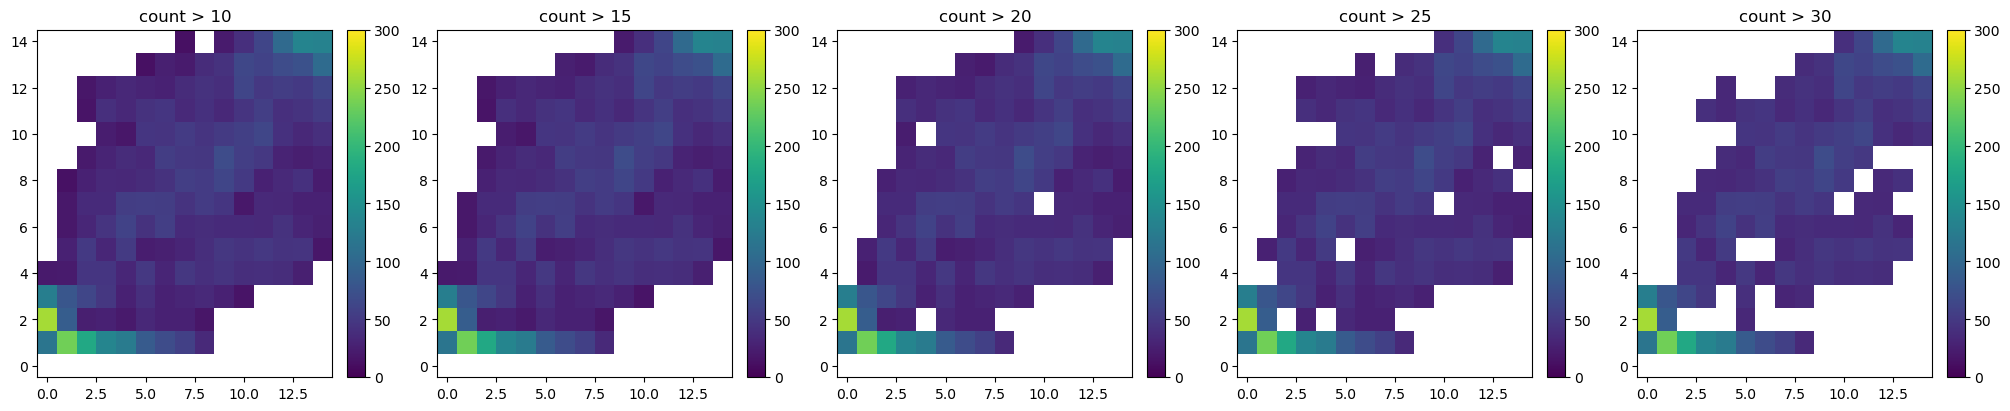

In [53]:
jh = qbinned_mean.joint_hist.isel(member=1)
fig, ax = plt.subplots(1, 5, figsize=(20, 4), layout="constrained")
for i in range(5):
    jh.where(jh > 10+i*5).plot(ax=ax[i], add_labels=False, vmin=0, vmax=300)
    ax[i].set_title(f"count > {10+i*5}")

In [68]:
nb = 15

Y = (FHIST["ET_year_1"].sel(member=slice(1, None)) - FHIST["ET_year_1"].sel(member=0)).where(NONGLC_MASK).mean(dim="year")
xb_def = FHIST["PRDIFF_year_1"].sel(member=0).where(NONGLC_MASK).mean(dim="year")
yb_def = FHIST["TLAI_year_1"].sel(member=0).where(NONGLC_MASK).mean(dim="year")
xnb = nb
ynb = nb
agg_dims=["gridcell"]

Y_s = Y.stack(gridcell=["lat", "lon"])
xb_def_s = xb_def.stack(gridcell=["lat", "lon"])
yb_def_s = yb_def.stack(gridcell=["lat", "lon"])

xb_def_qedge = xclim.get_quantiles(xb_def_s, xnb, ["gridcell"])
yb_def_qedge = xclim.get_quantiles(yb_def_s, ynb, ["gridcell"])

xb_def_bin = xclim.get_bins(xb_def_s, xb_def_qedge)
yb_def_bin = xclim.get_bins(yb_def_s, yb_def_qedge)

binned_mean = xclim.get_binned_mean2d(Y_s, xb_def_bin, yb_def_bin, xnb, ynb, agg_dims=agg_dims)

In [ ]:
nb = 15

xb = FHIST["PRDIFF_year_1"].where(NONGLC_MASK).mean(dim="year")
yb = FHIST["TLAI_year_1"].where(NONGLC_MASK).mean(dim="year")
xnb = nb
ynb = nb
agg_dims=["gridcell"]

xb_s = xb.stack(gridcell=["lat", "lon"])
yb_s = yb.stack(gridcell=["lat", "lon"])

xb_qedge = xclim.get_quantiles(xb_s, xnb, ["gridcell"])
yb_qedge = xclim.get_quantiles(yb_s, ynb, ["gridcell"])

In [ ]:
yb_qedge.isel(member=0).plot()

NameError: name 'yb_qedge' is not defined

---

In [ ]:
N_BINS = 15
QUANTILE_EDGES = np.linspace(0, 1, N_BINS + 1)

# Compute quantiles to get bin edges
# TODO: should I compute across all years?
tlai_gridcell, tlai_quantiles = xclim.get_quantiles(FHIST["TLAI_year_1"], N_BINS, "")
wdfrq_gridcell, wdfrq_quantiles = xclim.get_quantiles(FHIST["WDFRQ_year_1"], N_BINS, "")
prdiff_gridcell, prdiff_quantiles = xclim.get_quantiles(FHIST["PRDIFF_year_1"], N_BINS, "")

TypeError: get_quantiles() missing 1 required positional argument: 'qdim'

Text(0, 0.5, 'annual PRECT difference highest and lowest month')

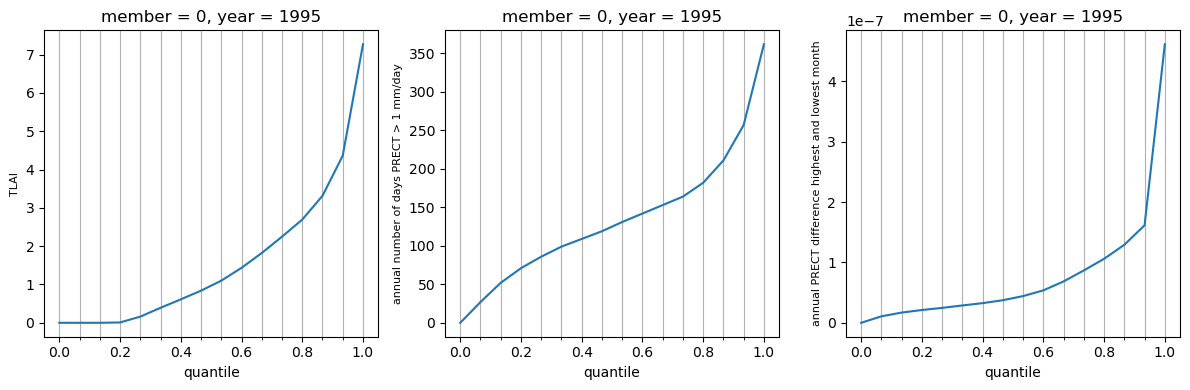

In [ ]:
iy = 0
im = 0

fig, ax = plt.subplots(1, 3, figsize=(12, 4), layout="tight")
tlai_quantiles.isel(year=iy, member=im).plot(ax=ax[0], marker="o")
wdfrq_quantiles.isel(year=iy, member=im).plot(ax=ax[1], marker="o")
prdiff_quantiles.isel(year=iy, member=im).plot(ax=ax[2], marker="o")

ax2 = []
for a in ax:
    ax2.append(a.twinx())
    a.set_xticks(QUANTILE_EDGES, minor=True)
    a.grid(axis="x", which="both")

# TODO: add low alpha bars that display the count in each quantile bin with right y-axis (i.e., a histogram)
# tlai_bins

ax[0].set_ylabel("TLAI", fontsize=8)
ax[1].set_ylabel("annual number of days PRECT > 1 mm/day", fontsize=8)
ax[2].set_ylabel("annual PRECT difference highest and lowest month", fontsize=8)

In [ ]:
# Assign each gridcell to a bin using searchsorted
tlai_bins = xclim.get_bins(tlai_gridcell, tlai_quantiles)
wdfrq_bins = xclim.get_bins(wdfrq_gridcell, wdfrq_quantiles)
prdiff_bins = xclim.get_bins(prdiff_gridcell, prdiff_quantiles)

# Clip bins to ensure valid values
tlai_bins  = tlai_bins.clip(0, N_BINS)
wdfrq_bins = wdfrq_bins.clip(0, N_BINS)
prdiff_bins = prdiff_bins.clip(0, N_BINS)

# Create 2D joint distribution using histogram2d (NaNs automatically excluded)
joint_tlai_wdfrq = xclim.get_joint_hist(tlai_bins, wdfrq_bins, N_BINS, N_BINS, agg_dims=["gridcell"])
joint_tlai_wdfrq = joint_tlai_wdfrq.rename({"x_bin": "TLAI_bin", "y_bin": "WDFRQ_bin"})

joint_tlai_prdiff = xclim.get_joint_hist(tlai_bins, prdiff_bins, N_BINS, N_BINS, agg_dims=["gridcell"])
joint_tlai_prdiff = joint_tlai_prdiff.rename({"x_bin": "TLAI_bin", "y_bin": "PRDIFF_bin"})

Text(0.5, 0.98, 'Member 0, 1995')

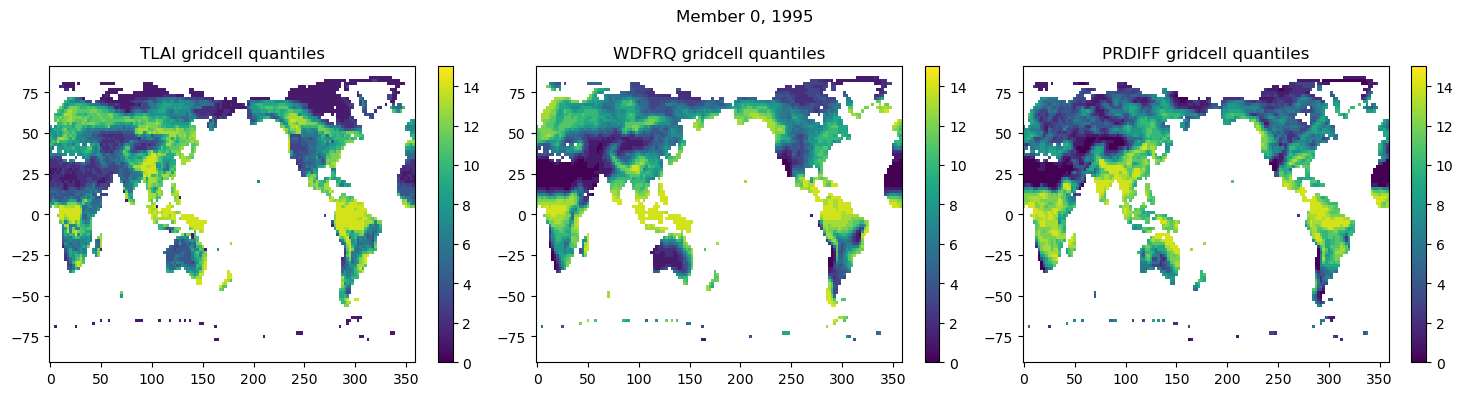

In [239]:
iy = 0
im = 0

fig, ax = plt.subplots(1, 3, figsize=(15, 4), layout="tight")
tlai_bins.isel(year=iy, member=im).unstack().plot(ax=ax[0], add_labels=False, vmin=0, vmax=N_BINS)
wdfrq_bins.isel(year=iy, member=im).unstack().plot(ax=ax[1], add_labels=False, vmin=0, vmax=N_BINS)
prdiff_bins.isel(year=iy, member=im).unstack().plot(ax=ax[2], add_labels=False, vmin=0, vmax=N_BINS)
ax[0].set_title("TLAI gridcell quantiles")
ax[1].set_title("WDFRQ gridcell quantiles")
ax[2].set_title("PRDIFF gridcell quantiles")
fig.suptitle(f"Member {im}, {tlai_bins.year[iy].item()}")

Text(0.5, 0.98, 'Member 0, 1995')

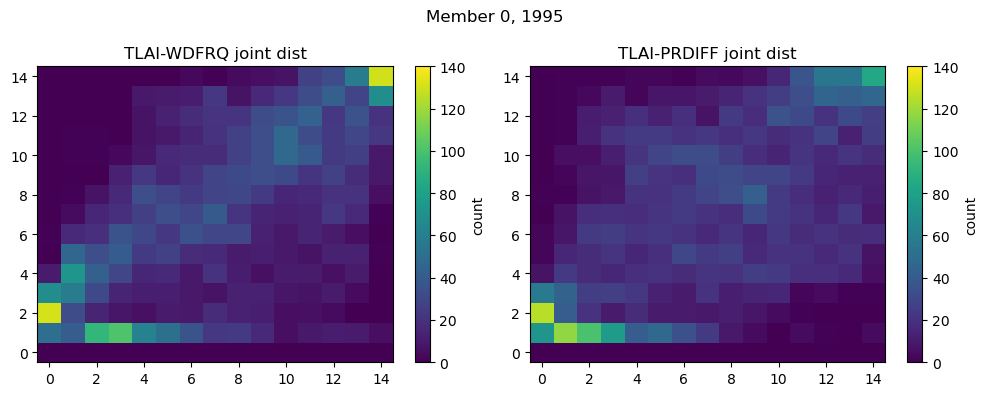

In [240]:
iy = 0
im = 0

fig, ax = plt.subplots(1, 2, figsize=(10, 4), layout="tight")
joint_tlai_wdfrq.isel(year=iy, member=im).unstack().plot(ax=ax[0], add_labels=False, vmin=0, vmax=140, cbar_kwargs={"label": "count"})
joint_tlai_prdiff.isel(year=iy, member=im).unstack().plot(ax=ax[1], add_labels=False, vmin=0, vmax=140, cbar_kwargs={"label": "count"})
ax[0].set_title("TLAI-WDFRQ joint dist")
ax[1].set_title("TLAI-PRDIFF joint dist")
fig.suptitle(f"Member {im}, {tlai_bins.year[iy].item()}")